CS5242 Final Project : Model Training Notebook
===
> Transfer learning and fine-tuning pre-trained models on ImageNet dataset

*Murat Shagirov*

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from nn import train_model # model training function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from datautils import LoadTrainingData
from torch.utils.data import DataLoader
from torchvision import models, utils, transforms as T

from datautils import BatchUnnorm, Unnorm

import numpy as np
from os import path

# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

# Transforms
unnorm = Unnorm() # unnormalize a single RGB image
unnormb = BatchUnnorm() # unnormalize batch of images

toPIL = T.ToPILImage()

img_size = 512

transform = T.Compose([T.ToPILImage(),
                       T.RandomRotation((-3,3)),
                       T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                       T.RandomHorizontalFlip(),
#                        T.RandomVerticalFlip(),
                       T.ToTensor(),
                       T.ConvertImageDtype(dtype), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = T.Compose([T.ToPILImage(),
                           T.Resize(img_size),
                           T.ToTensor(),
                           T.ConvertImageDtype(dtype),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

np.random.seed(42) #seed np RNG for consistency
# split the original training data into 85% / 15% train/val datasets
datasets = LoadTrainingData(train_csv, train_data_path, transform=transform,
                            split=True, train_percent=80, val_transform=val_transform)

print(f"Training dataset: {len(datasets['train'])} samples.",
      f"\nValidation dataset: {len(datasets['val'])} samples.")


device: cuda
dtype: torch.float32
Training dataset: 931 samples. 
Validation dataset: 233 samples.


In [2]:
# For plotting
import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,5) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

## Finetuning

- fine tuning resnet18 seems faster, and validation set acc-y is generally quickly reaches >85-90% after 5epochs
- using resnet18's conv layer as feature extractor (freezing them) results in very slow training (but no overfitting), both training and val-n set accuracies increase slowly (>80% after 5 epochs)

- densenet121: so far 25*3 epochs-->97.4249%
- resnext50_32x4d + fc: 25*1 epochs-->96.5665% (afterwards ValLoss converges to ~96%)

In [10]:
num_epochs = 10

bsize_train = 4 # batch sizes
bsize_val = 4

lr = 0.001 # learning rate

model_name = 'densenet121_v3'
# Download ImageNet pre-trained model from torchhub
model_ft = models.densenet121(pretrained=True,progress=False)

# # for transfer learning freeze (disable grads for early layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

# num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier.in_features

# size of each output sample: nn.Linear(num_ftrs, len(class_names)).
# e.g.: model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft.classifier = nn.Linear(num_ftrs, 3)


model_ft = model_ft.to(device)

# Finetune all parameters
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
# optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=lr)

# LR Schedules
# exp_lr_scheduler = None
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5*len(datasets['train']), gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4, step_size_up=5, step_size_down=10)

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}

Epoch 0/9 --- train Loss: 0.6418 Acc: 0.7197 || val Loss: 0.4243 Acc: 0.8240 || 50s
Epoch 1/9 --- train Loss: 0.5783 Acc: 0.7615 || val Loss: 0.2560 Acc: 0.8841 || 101s
Epoch 2/9 --- train Loss: 0.4490 Acc: 0.8153 || val Loss: 0.3058 Acc: 0.8541 || 151s
Epoch 3/9 --- train Loss: 0.4025 Acc: 0.8432 || val Loss: 0.4157 Acc: 0.8670 || 201s
Epoch 4/9 --- train Loss: 0.3089 Acc: 0.8861 || val Loss: 0.1532 Acc: 0.9356 || 251s
Epoch 5/9 --- train Loss: 0.3135 Acc: 0.8894 || val Loss: 0.1450 Acc: 0.9442 || 300s
Epoch 6/9 --- train Loss: 0.2631 Acc: 0.8915 || val Loss: 0.1161 Acc: 0.9528 || 350s
Epoch 7/9 --- train Loss: 0.2065 Acc: 0.9205 || val Loss: 0.1876 Acc: 0.9356 || 401s
Epoch 8/9 --- train Loss: 0.2434 Acc: 0.9108 || val Loss: 0.2314 Acc: 0.9099 || 451s
Epoch 9/9 --- train Loss: 0.1974 Acc: 0.9302 || val Loss: 0.1462 Acc: 0.9227 || 501s
Training complete in 8m 21s
Best val Acc: 0.952790 (return best:True)


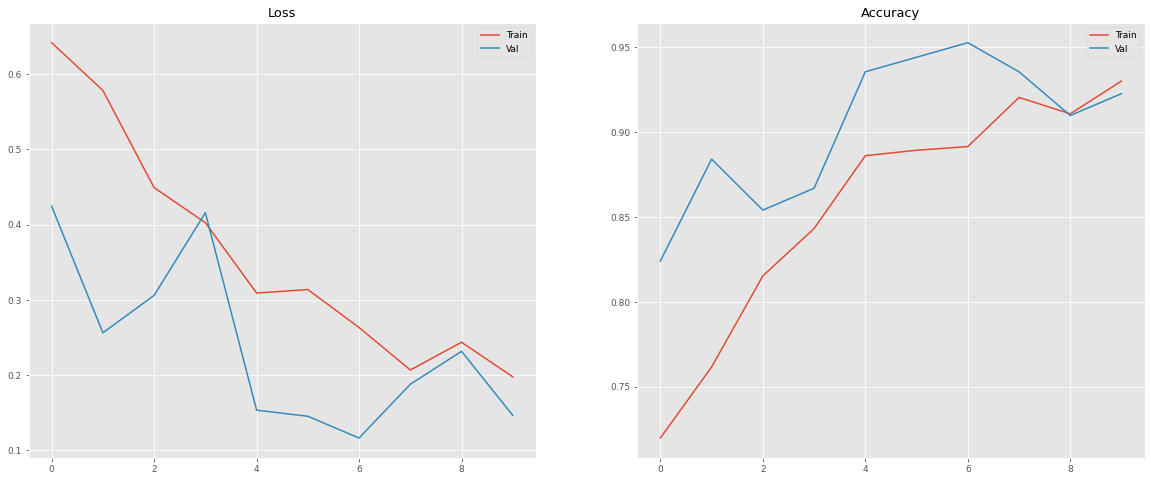

In [11]:
# for submission num_epochs > 60 epochs
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# UNCOMMENT below for plotting loss and accuracy

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()

In [8]:
# ======================================================= #
# ------------------- MODEL CHECKPOINT ------------------ #
# ======================================================= #
# Save (current) best model:
model_fname = 'densenet121_ft_512px_v2' # file name
save_dir = '../../dataDIR/cs5242/' # path to folder

torch.save(best_model.state_dict(), f'./{path.join(save_dir, model_fname)}.pkl')
# Save training/val losses and accuracies for plotting 
torch.save(curve_data,f'./{path.join(save_dir, model_fname)}_plot.pkl')

Epoch 0/99 --- train Loss: 0.2039 Acc: 0.9280 || val Loss: 0.1342 Acc: 0.9442 || 49s
Epoch 1/99 --- train Loss: 0.1597 Acc: 0.9356 || val Loss: 0.2091 Acc: 0.9227 || 99s
Epoch 2/99 --- train Loss: 0.1622 Acc: 0.9366 || val Loss: 0.1563 Acc: 0.9185 || 150s
Epoch 3/99 --- train Loss: 0.1292 Acc: 0.9527 || val Loss: 0.2503 Acc: 0.9185 || 201s
Epoch 4/99 --- train Loss: 0.1485 Acc: 0.9452 || val Loss: 0.1187 Acc: 0.9528 || 252s
Epoch 5/99 --- train Loss: 0.1201 Acc: 0.9517 || val Loss: 0.2202 Acc: 0.9356 || 302s
Epoch 6/99 --- train Loss: 0.1125 Acc: 0.9592 || val Loss: 0.3045 Acc: 0.9013 || 351s
Epoch 7/99 --- train Loss: 0.1470 Acc: 0.9484 || val Loss: 0.1540 Acc: 0.9227 || 400s
Epoch 8/99 --- train Loss: 0.0906 Acc: 0.9689 || val Loss: 0.1499 Acc: 0.9442 || 451s
Epoch 9/99 --- train Loss: 0.0616 Acc: 0.9796 || val Loss: 0.1316 Acc: 0.9528 || 500s
Epoch 10/99 --- train Loss: 0.1002 Acc: 0.9678 || val Loss: 0.1420 Acc: 0.9442 || 549s
Epoch 11/99 --- train Loss: 0.0844 Acc: 0.9721 || val L

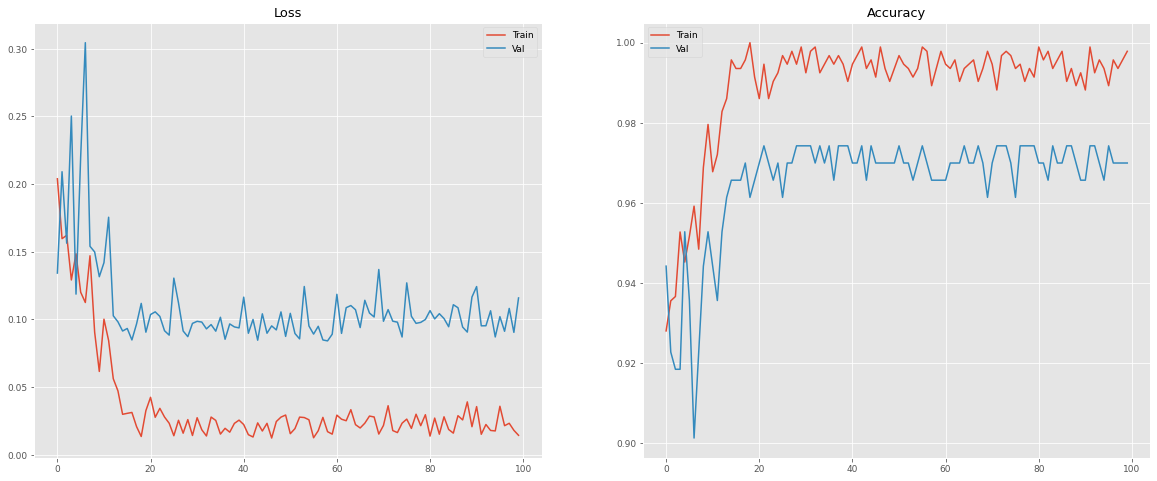

In [14]:
# # For changing LR-policy:
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3*len(datasets['train']), gamma=0.1)

# # continue training:
# best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=100,
#                          loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()

In [13]:
# ======================================================= #
# ------------------ Transfer Learning ------------------ #
# ======================================================= #
# My attempts on transfer learning
# fine-tuning results (above) were always better.
# Probable cause: I suspect, I did not disable BN layers in the convnet layers properly.
# Transfer learning performance on val dataset:
# - SGD moment0.9 lr=0.01: >90% (25 epochs)
# - SGD //-// lr= 0.01 step(20 epochs decay): 92% (100 epochs)
# ------------------------------------------------------- #

# num_epochs = 25

# bsize_train = 4 # batch sizes
# bsize_val = 4

# lr = 0.001 # learning rate

# # Download ImageNet pre-trained model from torchhub
# model_ft = models.resnet18(pretrained=True,progress=False)

# # for transfer learning freeze (disable grads for early layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

# num_ftrs = model_ft.fc.in_features

# # size of each output sample: nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Sequential( nn.Linear(num_ftrs, num_ftrs),
#                           nn.ReLU(),
#                          nn.Linear(num_ftrs, 3))

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=0.9)
# # optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=lr)

# # Decay LR by a factor of 0.1 every 7 epochs
# # exp_lr_scheduler = None
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5*len(datasets['train']), gamma=0.1)
# # exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
# #                                          step_size_up=5, step_size_down=10)

# # Prepare dataloaders
# data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
#                 'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}
# best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
#                          loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()

# train_method = 'tr'
# model_name = 'resnet18'
# save_dir = '../../dataDIR/cs5242/'
# weights_path = path.join(save_dir, f'{model_name}_{train_method}_v1.pkl')
# torch.save(best_model.state_dict(), weights_path)
# torch.save(curve_data,f'./{model_name}_{train_method}_plot_v1.pkl')


# ======================================================= #
# ---------- Fine tuning for transfer learning: --------- #
# ======================================================= #
# Uncomment this section for fine-tuning (after pre-training the classifier/ FC layer)

# num_epochs = 50

# # re-enable grads for fine-tuning
# for param in model_ft.parameters():
#     param.requires_grad = True
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
#                          loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()
# ======================================================= #

